<a href="https://colab.research.google.com/github/sofiadutta/CycleGAN-PyTorch/blob/master/Sentiment-Analysis-using-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import time
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from collections import Counter
from sklearn.metrics import accuracy_score

import gzip
import gensim
import os
import sys
import json
import shutil
import re
import tarfile
import zipfile


import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
!pip install wget
import wget


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=4b048c7418df45469d2da910e232334f94d8a0aa306f4076061dde1adcaae150
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


### **1.Create a dataset loader for the IMDB reviews dataset here (You will need to write some python code to download and extract it in your notebook!). Use it to load the training/testing set, and break reviews up by words. (i.e., "This movie was terrible!" -> ["this", "movie", "was", "terrible"] -> torch.tensor([1, 8, 2, 9])**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

import sys
sys.path.append('/content/gdrive/My Drive/MPDL/')

from mpdl import train_simple_network, Flatten, weight_reset

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [0]:
os.makedirs('/content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta')

In [0]:
os.chdir('/content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta')
!ls

**Python code to download extract IMDB Reviews Dataset**

In [0]:

data_source_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
print('Data source url : ',data_source_url)

Data source url :  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz


In [0]:
def check_if_file_exists(file):
    '''
    Checks if 'file' exists
    '''
    try:
        tarfh = tarfile.open(file)
        return True
    except FileNotFoundError:
        print('Please make sure file: ' + file + ' is present before continuing')
        return False

def check_if_dir_exists(directory):
    '''
    Checks if 'directory' exists
    '''
    return(os.path.isdir(directory))

In [0]:
data_file_path='/content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb_v1.tar.gz'
if not check_if_file_exists(data_file_path):
    print('Start of data download')
    wget.download(url=data_source_url, out='/content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta')
    print('Download complete')
else:
    print('Data file already exists. Not downloading again!')

Please make sure file: /content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb_v1.tar.gz is present before continuing
Start of data download
Download complete


In [0]:
data_folder='/content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb'
if not check_if_dir_exists(data_folder):
    startTime = time.time()
    tar = tarfile.open(data_file_path)
    print('Extracting all the files now...')
    tar.extractall()
    tar.close()
    print('Done!') 
    total_time=time.time()-startTime
    print('Time Taken for extracting all files : ',total_time/60,'minutes')
else:
    print('Data foler exists. Won\'t copy again!')

Extracting all the files now...
Done!
Time Taken for extracting all files :  25.22191904783249 minutes


**Loading the training/testing set, and breaking reviews up by words.**

[Load Data Link](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/)

In [0]:
def review_preprocess(review):
    """
    Takes in a string of review, then performs the following:
    1. Remove HTML tag from review
    2. Remove URLs from review
    3. Make entire review lowercase
    4. Split the review in words
    5. Remove all punctuation
    6. Remove empty strings from review
    7. Remove all stopwords
    8. Returns a list of the cleaned review after jioning them back to a sentence
    """
    en_stops = set(stopwords.words('english'))
    
    """
    Removing HTML tag from review
    """
    clean = re.compile('<.*?>')
    review_without_tag = re.sub(clean, '', review) 
    
    
    """
    Removing URLs
    """
    review_without_tag_and_url = re.sub(r"http\S+", "", review_without_tag)
    
    review_without_tag_and_url = re.sub(r"www\S+", "", review_without_tag)
    
    """
    Make entire string lowercase
    """
    review_lowercase = review_without_tag_and_url.lower()
    
    """
    Split string into words
    """
    list_of_words = word_tokenize(review_lowercase)
    
    
    """
    Remove punctuation
    Checking characters to see if they are in punctuation
    """

    list_of_words_without_punctuation=[''.join(this_char for this_char in this_string if (this_char in string.ascii_lowercase))for this_string in list_of_words]
     
    
    """
    Remove empty strings
    """
    list_of_words_without_punctuation = list(filter(None, list_of_words_without_punctuation))
    
    
    """
    Remove any stopwords
    """
  
    filtered_word_list = [w for w in list_of_words_without_punctuation if w not in en_stops] 
    
    """
    Returns a list of the cleaned review after jioning them back to a sentence
    """
    return ' '.join(filtered_word_list)


"""
Load file into memory
"""
def load_file(filename):
    """
    Open the file as read only
    """
    file = open(filename, 'r')
    """
    Read all text
    """
    text = file.read()
    """
    Close the file
    """
    file.close()
    return text

def get_data(directory, vocab, is_trian):
    """
    Reading train test directory
    """
    review_dict={'neg':[],'pos':[]}
    if is_trian:
        directory = os.path.join(directory+'/train')
    else:
        directory = os.path.join(directory+'/test')
    print('Directory : ',directory)
    for label_type in ['neg', 'pos']: 
            data_folder=os.path.join(directory, label_type)
            print('Data Folder : ',data_folder)
            for root, dirs, files in os.walk(data_folder):
                for fname in files:
                    if fname.endswith(".txt"):
                        file_name_with_full_path=os.path.join(root, fname)
                        review=load_file(file_name_with_full_path)
                        clean_review=review_preprocess(review)
                        if label_type == 'neg':
                            review_dict['neg'].append(clean_review)
                        else:
                            review_dict['pos'].append(clean_review)
                        """
                        Update counts
                        """
                        vocab.update(clean_review.split())
                        
    return review_dict

In [0]:
"""
Define vocab
"""
startTime = time.time()
vocab = Counter()
directory='/content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb'
train_review_dict=get_data(directory, vocab, True)
test_review_dict=get_data(directory, vocab, False)
total_time=time.time()-startTime
print('Time Taken : ',total_time/60,'minutes')

Directory :  /content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb/train
Data Folder :  /content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb/train/neg
Data Folder :  /content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb/train/pos
Directory :  /content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb/test
Data Folder :  /content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb/test/neg
Data Folder :  /content/gdrive/My Drive/HW2_Datasets_Sofia_Dutta/aclImdb/test/pos
Time Taken :  2.894369538625081 minutes


In [0]:
print('Number of negative reviews in train set :',len(train_review_dict['neg']))
print('Number of positive reviews in train set :',len(train_review_dict['pos']))

print('\nNumber of negative reviews in test set :',len(test_review_dict['neg']))
print('Number of positive reviews in test set :',len(test_review_dict['pos']))

Number of negative reviews in train set : 12500
Number of positive reviews in train set : 12500

Number of negative reviews in test set : 12500
Number of positive reviews in test set : 12500


In [0]:
print('First five entires : ')
print(train_review_dict['pos'][:5])
print(train_review_dict['neg'][:5])
print(test_review_dict['pos'][:5])
print(test_review_dict['neg'][:5])

First five entires : 
['zentropa much common third man another noirlike film set among rubble postwar europe like ttm much inventive camera work innocent american gets emotionally involved woman nt really understand whose naivety striking contrast nativesbut say third man wellcrafted storyline zentropa bit disjointed respect perhaps intentional presented dreamnightmare making coherent would spoil effect movie unrelentingly grim noir one sense one never sees sun shine grim intriguing frightening', 'zentropa original movie seen years like unique thrillers influenced film noir right cure hollywood summer blockbusters clogging theaters days von trier followups like breaking waves gotten acclaim really best work flashy without distracting offers perfect combination suspense dark humor bad decided handheld cameras wave future hard say talked away style exhibits everyone loss went heavily theoretical dogma direction instead', 'lars von trier never backward trying new techniques original other

In [0]:
word_list = sorted(vocab, key = vocab.get, reverse = True)
vocab_to_int = {word:idx+1 for idx, word in enumerate(word_list)}
int_to_vocab = {idx:word for word, idx in vocab_to_int.items()}

**Creating a dataset loader for the IMDB reviews dataset**

In [0]:
class IMDBReviewDataset(Dataset):
    
    def __init__(self, review_dict, alphabet):
        
        self.data = review_dict
        self.labels = [x for x in review_dict.keys()]
        self.alphabet = alphabet
        
    def __len__(self):
        return sum([len(x) for x in self.data.values()])
    
    def __getitem__(self, idx):
        label = 0
        while idx >= len(self.data[self.labels[label]]):
            idx -= len(self.data[self.labels[label]])
            label += 1
        reviewText = self.data[self.labels[label]][idx]
        
        
        
        label_vec = torch.zeros((1), dtype=torch.long)
        label_vec[0] = label
        return self.reviewText2InputVec(reviewText), label
    
    def reviewText2InputVec(self, review_text):
        T = len(review_text)
        
        review_text_vec = torch.zeros((T), dtype=torch.long)
        encoded_review=[]
        for pos,word in enumerate(review_text.split()):
            if word not in vocab_to_int.keys():
                """
                If word is not available in vocab_to_int dict puting 0 in that place
                """
                review_text_vec[pos]=0
            else:
                review_text_vec[pos]=vocab_to_int[word]
            
        return review_text_vec
    


**Down Sampling**
* Need to down sample the training set to make training faster.
* Training set contains balanced number of positive and negative reviews.(12500 positive and 12500 negative reviews.)
* For Fatser taraining as RNN is computational expensive I downsampled the data.I Took 50% of the positive reviews of trainig set(6250 positive reviews) and 50% of the negative reviews of trainig set(6250 negative reviews).That way, reduced or down sampled training set contains balanced number of positive and negative reviews and would not create the unbalabced data point issues.Learning of the model is unbisaed as there will be no issue like learning one class gives maximum accuracy.

In [0]:
train_review_dict['pos']=train_review_dict['pos'][:int(len(train_review_dict['pos'])*.5)]
train_review_dict['neg']=train_review_dict['neg'][:int(len(train_review_dict['neg'])*.5)]
print('After Down Sampling the training set :')
print('Number of negative reviews in train set :',len(train_review_dict['neg']))
print('Number of positive reviews in train set :',len(train_review_dict['pos']))

After Down Sampling the training set :
Number of negative reviews in train set : 6250
Number of positive reviews in train set : 6250


In [0]:
def pad_and_pack(batch):
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    longest = max(lengths)
    #We need to pad all the inputs up to 'longest', and combine into a batch ourselves
    if len(input_tensors[0].shape) == 1:
        x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    else:
        raise Exception('Current implementation only supports (T) shaped data')
    
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    
    y_batched = torch.as_tensor(labels, dtype=torch.long)
        
    return x_packed, y_batched

In [0]:
B = 24
train_dataset=IMDBReviewDataset(train_review_dict,vocab)
test_dataset=IMDBReviewDataset(test_review_dict,vocab)

train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_and_pack)

### **2.Train some form of RNN model on the dataset. Its up to you to select the type, single-bidirectional, number of layers, etc. Explain your choices and show the comparisons that lead you to your conclusions! If you need to down sample the training set to make training faster, that is OK. Just explain why!**


In [0]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.to(input.data.device), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)


In [0]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [0]:
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

**RNN 3 Layer Bidirectional Model**

In [0]:
D = 32
alphabet_size = len(vocab)+1
hidden_nodes = 64
classes = len(train_dataset.labels)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(rnn_3layer_bidir.parameters(), lr=0.001*B)
epochs=10
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [0]:
rnn_3layer_bidir_results = train_network(rnn_3layer_bidir, loss_func, train_loader, val_loader=test_loader,
                                         epochs=epochs, optimizer=optimizer, lr_schedule=scheduler,
                                         score_funcs={'Accuracy': accuracy_score}, checkpoint_file='model_rnn_3layer_bidir.pt', device=device)



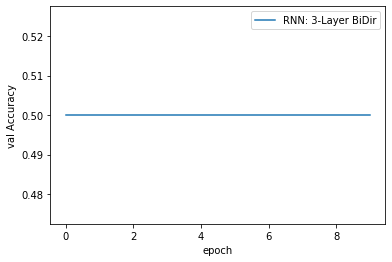

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results, label='RNN: 3-Layer BiDir')

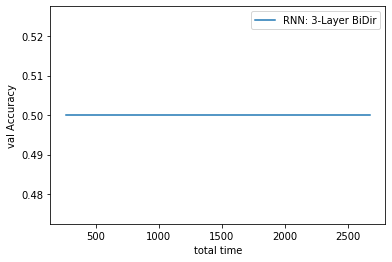

In [0]:
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results, label='RNN: 3-Layer BiDir')

In [0]:
device

device(type='cuda')

In [0]:
with torch.no_grad():
   correct = 0
   for X_test, y_test in test_loader:
       X_test=X_test.to(device)
       y_test=y_test.to(device)
       y_val = rnn_3layer_bidir(X_test)  
       predicted = torch.max(y_val,1)[1]
       correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

Test accuracy: 12500/25000 =  50.000%


**LSTM 3 Layer Bidirectional Model**

In [0]:
lstm = nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.LSTM(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

lstm.to(device)
optimizer = torch.optim.AdamW(lstm.parameters(), lr=0.001*B)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [0]:
lstm_results = train_network(lstm, loss_func, train_loader, val_loader=test_loader,
                                 epochs=epochs, optimizer=optimizer, lr_schedule=scheduler,
                                 score_funcs={'Accuracy': accuracy_score}, checkpoint_file='model_lstm.pt', device=device)


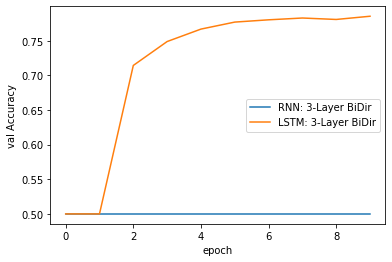

In [0]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results, label='RNN: 3-Layer BiDir')
sns.lineplot(x='epoch', y='val Accuracy', data=lstm_results, label='LSTM: 3-Layer BiDir')

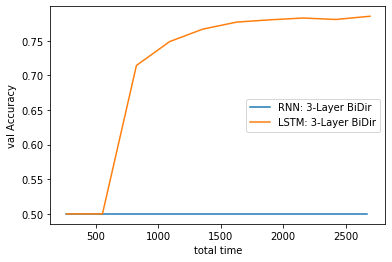

In [0]:
sns.lineplot(x='total time', y='val Accuracy', data=rnn_3layer_bidir_results, label='RNN: 3-Layer BiDir')
sns.lineplot(x='total time', y='val Accuracy', data=lstm_results, label='LSTM: 3-Layer BiDir')

In [0]:
model_name = 'LSTM_Three_Layer_BiDir.pt'
torch.save(lstm.state_dict(),model_name)

In [0]:
model_name = 'LSTM_Three_Layer_BiDir.pt'
lstm_model_new=nn.Sequential(
  EmbeddingPackable(nn.Embedding(alphabet_size, D)), #(B, T) -> (B, T, D)
  nn.LSTM(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)
lstm_model_new.load_state_dict(torch.load(model_name))
lstm_model_new.eval()

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(180673, 32)
  )
  (1): LSTM(32, 64, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=128, out_features=2, bias=True)
)

In [0]:
with torch.no_grad():
   correct = 0
   for X_test, y_test in test_loader:
       X_test=X_test.to(device)
       y_test=y_test.to(device)
       y_val = lstm(X_test)  
       predicted = torch.max(y_val,1)[1]
       correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

Test accuracy: 19635/25000 =  78.540%


* Tensors need all dimensions to be consistent and the same, but our time dimension due to varying length reviews are inconsistent. In order to not preventing an RNN in working with inputs of varying lengths of time used PyTorch's Packed Sequence abstraction.
* The embedding layer in PyTorch does not support Packed Sequence objects. Created EmbeddingPackable wrapper class to resolve the issue. For normal input, it will use the regular Embedding layer. Otherwise, it will work on the packed sequence to return a new Packed sequence of the appropriate result.
* For Training, I used AdamW optimizer and CosineAnnealingLR LR scheduler. AdamW uses unbiased estimates of the mean and variance, both together to update the weights of the parameters, gives better performance. It's an optimizer that, using the default values, will usually perform well. CosineAnnealingLR is one of the best ways to adjusting the learning rate which eventually increases the performance of the model.
* The essence of deep learning is to create multiple hidden layers for getting better performance so implemented multi-layer(3 Layers) RNN and LSTM.
* Created a bi-directional RNN and LSTM, so that, it can traverse the input in both directions at once, and share this information with the next layer of the model. This starts to accumulate information about time more evenly through the model and can make learning easier.
* The tried-and-true option that seems to always work well with sequence data is called a Long Short Term Memory (LSTM) network.LSTM using the gate functionality can decide which information to keep track of or forget. It uses forget gate to control whether or not the old context should be forgotten. It uses an input gate to control whether or not to add to the current context. It uses an output gate to control the next hidden state based on the current context. In this way, it can capture the long term dependencies in text and work well with sequence data, which is why I used it.
* LSTM 3-layer bidirectional model is the best performing model with a test accuracy of 78.54%